<a href="https://colab.research.google.com/github/kaburia/BLE_OpenMV/blob/main/Quantized_Aware_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip dataset.zip

In [ ]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
import keras
#use reducelronplateau and lrscheduling
#use transfer learning.

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
%matplotlib inline

import cv2
import io
import random
from PIL import Image
import time

from sklearn.model_selection import train_test_split
# Import models
from tensorflow.keras import layers, models
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet import ResNet152
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.models import load_model
import PIL
from keras.utils.vis_utils import plot_model
from IPython import display

import warnings
warnings.simplefilter("ignore")

from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score,precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
print('Libraries imported')

Libraries imported


### Post-training integer quantization
Integer quantization is an optimization strategy that converts 32-bit floating-point numbers (such as weights and activation outputs) to the nearest 8-bit fixed-point numbers.

In [ ]:
import logging
logging.getLogger("tensorflow").setLevel(logging.DEBUG)

import tensorflow as tf
import numpy as np
print("TensorFlow version: ", tf.__version__)

TensorFlow version:  2.12.0


In [ ]:
base_dir = '/content/dataset'

# test and train labels
test_dir_df = os.path.join(base_dir, 'test.csv')
train_dir_df = os.path.join(base_dir, 'train.csv')
df_train = pd.read_csv(train_dir_df)
df_test = pd.read_csv(test_dir_df)

# test and train images
test_dir = os.path.join(base_dir, 'test')
train_dir = os.path.join(base_dir, 'train')



In [ ]:
# set seed for reproducibility.
# set seed
seed = 2022

def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_everything(seed)

In [ ]:
dataset = tf.keras.utils.image_dataset_from_directory(base_dir, batch_size=1, image_size=(128, 128))

Found 2322 files belonging to 2 classes.


In [ ]:
df_train


,filename,region_count,region_shape_attributes,Device,Species,Count,Sex,Latitude,Longitude
0,2021-06-25-14-55-23.jpg,1,"{""name"":""rect"",""x"":1228,""y"":507,""width"":27,""he...",Raspberry Pi 2,WARTHOG,1,CAN'T TELL,-0.388557,36.961408
1,2021-06-25-15-06-49.jpg,1,"{""name"":""rect"",""x"":60,""y"":385,""width"":39,""heig...",Raspberry Pi 2,IMPALA,1,CAN'T TELL,-0.388557,36.961408
2,2021-06-25-15-39-54.jpg,1,"{""name"":""rect"",""x"":6,""y"":392,""width"":42,""heigh...",Raspberry Pi 2,WARTHOG,1,CAN'T TELL,-0.388557,36.961408
3,2021-06-25-15-40-46.jpg,1,"{""name"":""rect"",""x"":25,""y"":392,""width"":41,""heig...",Raspberry Pi 2,WARTHOG,1,CAN'T TELL,-0.388557,36.961408
4,2021-07-01-06-51-57.jpg,1,"{""name"":""rect"",""x"":663,""y"":413,""width"":45,""hei...",Raspberry Pi 2,IMPALA,1,FEMALE,-0.390386,36.962331
...,...,...,...,...,...,...,...,...,...
2081,snapshot_2019108341939198.jpg,1,"{""name"":""rect"",""x"":486,""y"":143,""width"":148,""he...",OpenMV Cam H7,ZEBRA,1,CAN'T TELL,-0.390381,36.962333
2082,snapshot_2019108341940172.jpg,1,"{""name"":""rect"",""x"":557,""y"":140,""width"":80,""hei...",OpenMV Cam H7,ZEBRA,1,CAN'T TELL,-0.390381,36.962333
2083,snapshot_2019108343230246.jpg,1,"{""name"":""rect"",""x"":306,""y"":166,""width"":125,""he...",OpenMV Cam H7,ZEBRA,1,CAN'T TELL,-0.390381,36.962333
2084,snapshot_2019108343231220.jpg,1,"{""name"":""rect"",""x"":316,""y"":156,""width"":99,""hei...",OpenMV Cam H7,ZEBRA,1,CAN'T TELL,-0.390381,36.962333


In [ ]:
!unzip figures.zip

Archive:  figures.zip
   creating: figures/
  inflating: figures/accuracy.PNG    
  inflating: figures/conservancy-animals.PNG  
  inflating: figures/conservancy.PNG  
  inflating: figures/dsa-arusha-dsail-logo.PNG  
  inflating: figures/f1-score.PNG    
  inflating: figures/process-data-science.png  
  inflating: figures/test_location.PNG  
  inflating: figures/training-validation-recall.PNG  
  inflating: figures/training-validation-recall1.PNG  
  inflating: figures/train_bar_graph.png  
  inflating: figures/train_location.PNG  


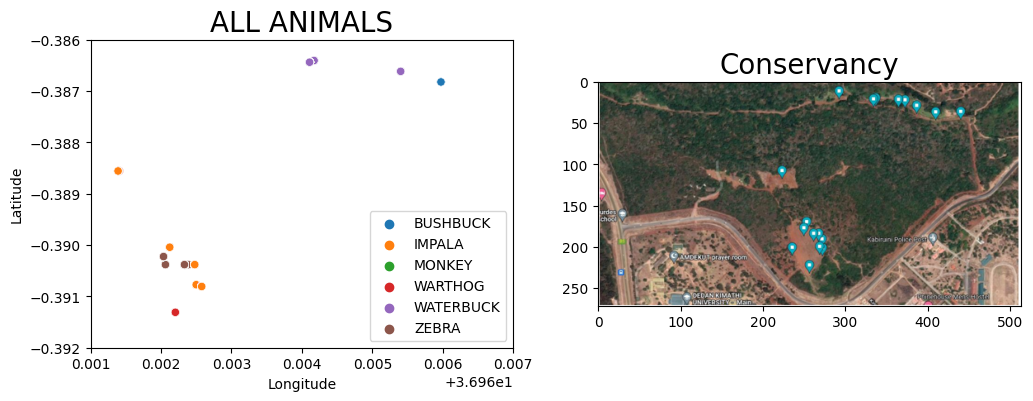

In [ ]:
#create the figure
fig = plt.figure(figsize =(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.set_title('ALL ANIMALS',fontdict = {'fontsize':20})
plt.ylim([-0.392,-0.386])
plt.xlim(36.961,36.967)
imgplot =  sns.scatterplot(data=df_train,x='Longitude',y='Latitude',hue='Species',hue_order = ['BUSHBUCK','IMPALA','MONKEY','WARTHOG','WATERBUCK','ZEBRA']);
plt.legend(loc='lower right')
ax = fig.add_subplot(1,2,2)
ax.set_title('Conservancy',fontdict = {'fontsize':20})
image_ = mpimg.imread('./figures/conservancy.PNG')
imgplot = plt.imshow(image_)
plt.show()

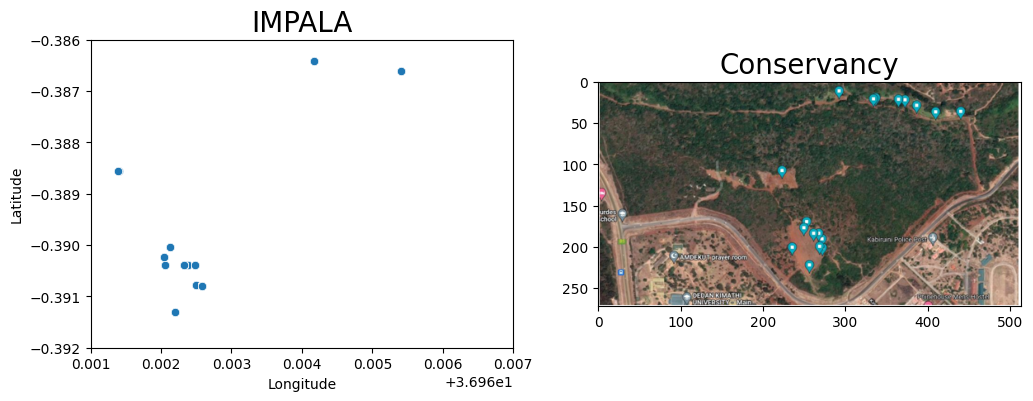

In [ ]:
#create the figure
animal = 'IMPALA'
def animal_location(animal):
    fig = plt.figure(figsize =(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    plt.ylim([-0.392,-0.386])
    plt.xlim(36.961,36.967)
    ax.set_title(animal,fontdict = {'fontsize':20})
    imgplot =  sns.scatterplot(data=df_train[df_train['Species']==animal],x='Longitude',y='Latitude');
    ax = fig.add_subplot(1,2,2)
    image_ = mpimg.imread('./figures/conservancy.PNG')
    ax.set_title('Conservancy',fontdict = {'fontsize':20})

    imgplot = plt.imshow(image_)
    plt.show()
animal_location(animal)

In [ ]:
#shape of the dataframes ?
print('Train labels :',df_train.shape)
print('Test labels :',df_test.shape)

test_ = df_test.shape[0]*["test"]
train_ = df_train.shape[0]*["train"]
df_test["df"] = test_
df_train["df"] = train_

#shape of the dataframes ?
print('Train labels :',df_train.shape)
print('Test labels :',df_test.shape)


Train labels : (2086, 9)
Test labels : (236, 9)
Train labels : (2086, 10)
Test labels : (236, 10)


In [ ]:
df = pd.concat([df_train, df_test])
df

,filename,region_count,region_shape_attributes,Device,Species,Count,Sex,Latitude,Longitude,df
0,2021-06-25-14-55-23.jpg,1,"{""name"":""rect"",""x"":1228,""y"":507,""width"":27,""he...",Raspberry Pi 2,WARTHOG,1,CAN'T TELL,-0.388557,36.961408,train
1,2021-06-25-15-06-49.jpg,1,"{""name"":""rect"",""x"":60,""y"":385,""width"":39,""heig...",Raspberry Pi 2,IMPALA,1,CAN'T TELL,-0.388557,36.961408,train
2,2021-06-25-15-39-54.jpg,1,"{""name"":""rect"",""x"":6,""y"":392,""width"":42,""heigh...",Raspberry Pi 2,WARTHOG,1,CAN'T TELL,-0.388557,36.961408,train
3,2021-06-25-15-40-46.jpg,1,"{""name"":""rect"",""x"":25,""y"":392,""width"":41,""heig...",Raspberry Pi 2,WARTHOG,1,CAN'T TELL,-0.388557,36.961408,train
4,2021-07-01-06-51-57.jpg,1,"{""name"":""rect"",""x"":663,""y"":413,""width"":45,""hei...",Raspberry Pi 2,IMPALA,1,FEMALE,-0.390386,36.962331,train
...,...,...,...,...,...,...,...,...,...,...
231,snapshot_2019109471034205.jpg,1,"{""name"":""rect"",""x"":547,""y"":116,""width"":90,""hei...",OpenMV Cam H7,IMPALA,1,CAN'T TELL,-0.390381,36.962333,test
232,snapshot_2019109471035142.jpg,1,"{""name"":""rect"",""x"":552,""y"":119,""width"":85,""hei...",OpenMV Cam H7,IMPALA,1,CAN'T TELL,-0.390381,36.962333,test
233,snapshot_20191083281848216.jpg,1,"{""name"":""rect"",""x"":183,""y"":2,""width"":456,""heig...",OpenMV Cam H7,WARTHOG,1,CAN'T TELL,-0.390381,36.962333,test
234,snapshot_20191083281849165.jpg,1,"{""name"":""rect"",""x"":182,""y"":2,""width"":454,""heig...",OpenMV Cam H7,WARTHOG,1,CAN'T TELL,-0.390381,36.962333,test


In [ ]:
from sklearn.preprocessing import OrdinalEncoder

ord_enc = OrdinalEncoder()
df["Species_code"] = ord_enc.fit_transform(df[["Species"]])
df.groupby(["Species"])['Species_code'].mean()

Species
BUSHBUCK     0.0
IMPALA       1.0
MONKEY       2.0
WARTHOG      3.0
WATERBUCK    4.0
ZEBRA        5.0
Name: Species_code, dtype: float64

In [ ]:
df_train = df[df['df'] == "train"]
df_test = df[df['df'] == "test"]

In [ ]:
num = 0
for file in list(df_train.filename):
    if file in os.listdir(train_dir):
        continue
    else:
        num +=1
if num == 0:
    print('Good Split!')
else:
    print('Error in split')

Good Split!


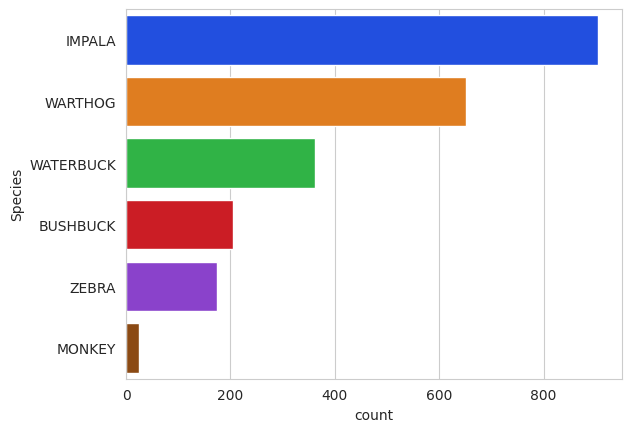

In [ ]:
#Plot Class Distribution
sns.set_style('whitegrid')
sns.countplot(y = df['Species'], data = df, palette = 'bright',order=df['Species'].value_counts().index);

In [ ]:
#To add Compare your model with pretrained model.
reverse_mapping = {
"BUSHBUCK":0.0,
"IMPALA":1.0,
"MONKEY":2.0,
"WARTHOG":3.0,
"WATERBUCK":4.0,
"ZEBRA":5.0,
}
mapping = {
    0.0:"BUSHBUCK",
    1.0:"IMPALA",
    2.0:"MONKEY",
    3.0:"WARTHOG",
    4.0:"WATERBUCK",
    5.0:"ZEBRA"
}
print(list(reverse_mapping.values()))
print(list(mapping.values()))

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
['BUSHBUCK', 'IMPALA', 'MONKEY', 'WARTHOG', 'WATERBUCK', 'ZEBRA']


In [ ]:
#load model
model = tf.keras.applications.mobilenet_v2.MobileNetV2(
    include_top=True,
    weights='imagenet',
    input_tensor=None,
    pooling=None,
    classes=1000)

14536120/14536120 [==============================] - 0s 0us/step


In [ ]:
preds = {}

for image in os.listdir(test_dir):
        x = tf.io.read_file(test_dir+'/'+image)
        x = tf.io.decode_image(x,channels=3)
        x = tf.image.resize(x,[224,224])
        x = tf.expand_dims(x, axis=0)
        x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
        abc = model.predict(x)
        p = tf.keras.applications.imagenet_utils.decode_predictions(
            abc, top=1
        )[0]
        preds[image] = [image,p[0][1],p[0][2]]
print("Done!")

In [ ]:
model.summary()

In [ ]:
df_train

,filename,region_count,region_shape_attributes,Device,Species,Count,Sex,Latitude,Longitude,df,Species_code
0,2021-06-25-14-55-23.jpg,1,"{""name"":""rect"",""x"":1228,""y"":507,""width"":27,""he...",Raspberry Pi 2,WARTHOG,1,CAN'T TELL,-0.388557,36.961408,train,3.0
1,2021-06-25-15-06-49.jpg,1,"{""name"":""rect"",""x"":60,""y"":385,""width"":39,""heig...",Raspberry Pi 2,IMPALA,1,CAN'T TELL,-0.388557,36.961408,train,1.0
2,2021-06-25-15-39-54.jpg,1,"{""name"":""rect"",""x"":6,""y"":392,""width"":42,""heigh...",Raspberry Pi 2,WARTHOG,1,CAN'T TELL,-0.388557,36.961408,train,3.0
3,2021-06-25-15-40-46.jpg,1,"{""name"":""rect"",""x"":25,""y"":392,""width"":41,""heig...",Raspberry Pi 2,WARTHOG,1,CAN'T TELL,-0.388557,36.961408,train,3.0
4,2021-07-01-06-51-57.jpg,1,"{""name"":""rect"",""x"":663,""y"":413,""width"":45,""hei...",Raspberry Pi 2,IMPALA,1,FEMALE,-0.390386,36.962331,train,1.0
...,...,...,...,...,...,...,...,...,...,...,...
2081,snapshot_2019108341939198.jpg,1,"{""name"":""rect"",""x"":486,""y"":143,""width"":148,""he...",OpenMV Cam H7,ZEBRA,1,CAN'T TELL,-0.390381,36.962333,train,5.0
2082,snapshot_2019108341940172.jpg,1,"{""name"":""rect"",""x"":557,""y"":140,""width"":80,""hei...",OpenMV Cam H7,ZEBRA,1,CAN'T TELL,-0.390381,36.962333,train,5.0
2083,snapshot_2019108343230246.jpg,1,"{""name"":""rect"",""x"":306,""y"":166,""width"":125,""he...",OpenMV Cam H7,ZEBRA,1,CAN'T TELL,-0.390381,36.962333,train,5.0
2084,snapshot_2019108343231220.jpg,1,"{""name"":""rect"",""x"":316,""y"":156,""width"":99,""hei...",OpenMV Cam H7,ZEBRA,1,CAN'T TELL,-0.390381,36.962333,train,5.0


In [ ]:
# train directory from the species column move the unique species to their respective directories
import shutil

for ind, row in df_train.iterrows():
  print(row['Species'])
  if os.path.exists('train') is False:
    os.mkdir('train')
  else:
    if os.path.exists(f'train/{row["Species"]}') is False:
      os.mkdir(f'train/{row["Species"]}')
      shutil.copy(f'{train_dir}/{row["filename"]}', f'train/{row["Species"]}')
    else:
      shutil.copy(f'{train_dir}/{row["filename"]}', f'train/{row["Species"]}')





In [ ]:
def split_data(image_dir, label_df, value):
  '''
  value - the type either test or train
  label_df - the dataframe containing the labels of the classes
  image_dir - the directory containing the images
  '''
  for ind, row in label_df.iterrows():
    print(row['Species'])
    if os.path.exists(f'{value}') is False:
      os.mkdir(f'{value}')
    else:
      if os.path.exists(f'{value}/{row["Species"]}') is False:
        os.mkdir(f'{value}/{row["Species"]}')
        shutil.copy(f'{image_dir}/{row["filename"]}', f'{value}/{row["Species"]}')
      else:
        shutil.copy(f'{image_dir}/{row["filename"]}', f'{value}/{row["Species"]}')

Splitting the dat to a format to easily create tensors

In [ ]:
split_data(test_dir, df_test, 'test')

(215, 216, 3)


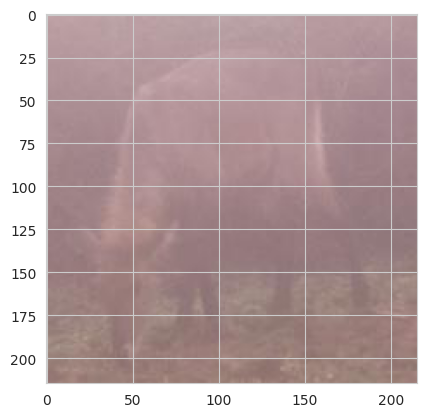

In [ ]:
# Checking a random image in the training directory

rand = random.choice(os.listdir(train_dir))
rand_im = np.array(Image.open(train_dir + '/' + rand))
plt.imshow(rand_im);
print(rand_im.shape)

In [ ]:
n_train_dir = '/content/train'
n_test_dir = '/content/test'

train_dataset = tf.keras.utils.image_dataset_from_directory(
    n_train_dir,
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    validation_split=0.2,
    subset="training",
    seed = seed
)

# Extract the train images and labels
train_images = []
train_labels = []

for images, labels in dataset:
    train_images.append(images.numpy()[0])
    train_labels.append(labels.numpy()[0])

train_images = np.array(train_images)
train_labels = np.array(train_labels)

# Load the dataset again, this time for testing/validation
test_dataset = tf.keras.utils.image_dataset_from_directory(
    n_test_dir,
    batch_size=32,
    image_size=(128, 128),
    seed=2022
)

# Extract the test images and labels
test_images = []
test_labels = []

for images, labels in test_dataset:
    test_images.append(images.numpy()[0])
    test_labels.append(labels.numpy()[0])

test_images = np.array(test_images)
test_labels = np.array(test_labels)

# normalizing the values
train_images = train_images.astype(np.float32) / 255.0
test_images = test_images.astype(np.float32) / 255.0


Found 2086 files belonging to 6 classes.
Using 1669 files for training.
Found 236 files belonging to 6 classes.


In [ ]:
test_images.shape

(8, 128, 128, 3)

In [ ]:
# Define the model architecture
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(6)
])

# Train the digit classification model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(
                  from_logits=True),
              metrics=['accuracy'])
model.fit(
  train_images,
  train_labels,
  epochs=5,
  validation_data=(test_images, test_labels)
)

Epoch 1/5
73/73 [==============================] - 5s 29ms/step - loss: 0.3551 - accuracy: 0.8880 - val_loss: 9.1965 - val_accuracy: 0.5000
Epoch 2/5
73/73 [==============================] - 1s 14ms/step - loss: 0.2353 - accuracy: 0.9053 - val_loss: 12.2247 - val_accuracy: 0.3750
Epoch 3/5
73/73 [==============================] - 1s 13ms/step - loss: 0.2177 - accuracy: 0.9225 - val_loss: 14.4251 - val_accuracy: 0.1250
Epoch 4/5
73/73 [==============================] - 1s 12ms/step - loss: 0.1946 - accuracy: 0.9251 - val_loss: 13.5358 - val_accuracy: 0.1250
Epoch 5/5
73/73 [==============================] - 1s 12ms/step - loss: 0.1623 - accuracy: 0.9376 - val_loss: 13.4694 - val_accuracy: 0.1250


In [ ]:
import tensorflow as tf
from keras.models import load_model

# model = load_model('mobilenet.h5')

def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(train_images).batch(1).take(100):
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant = converter.convert()



INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 3, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fee26ee1630>, 140660831890096), {}).
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fee26f0d4b0>, 140660831915024), {}).
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(47628, 6), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fee26f0f2b0>, 140660831893136), {}).
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(6,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fee26f39150>, 140660831893376), {}).
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 3, 12

In [ ]:
import tensorflow as tf

# Define the serving function
@tf.function(input_signature=[tf.TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32)])
def serving_fn(input_image):
    return model(input_image)

# Convert the model using the serving function
converter = tf.lite.TFLiteConverter.from_concrete_functions([serving_fn.get_concrete_function()])
tflite_model = converter.convert()


In [ ]:
with open('tflite_quant_modeld.tflite', 'wb') as f:
  f.write(tflite_model_quant)


In [ ]:
print('Model Size: ', os.path.getsize('tflite_quant_modeld.tflite')/1024,'KB')

Model Size:  282.4921875 KB


In [ ]:
# TODO: Define your transforms for the training, validation, and testing sets
from random import shuffle
# Imports here
from torch import nn
from torch import optim
import torch

import matplotlib.pyplot as plt

from torchvision import datasets, transforms, models
import numpy as np
from PIL import Image


data_transforms = transforms.Compose((transforms.RandomRotation(30),
                                     transforms.RandomResizedCrop(128),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])))

# Test and validation transforms
test_transforms  = transforms.Compose((transforms.Resize(255),
                                      transforms.CenterCrop(128),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])))


# TODO: Load the datasets with ImageFolder
image_datasets = datasets.ImageFolder(n_train_dir, transform=data_transforms)

# Loading test data
test_image = datasets.ImageFolder(n_test_dir, transform=test_transforms)

# Vlaidation images
# test_image = datasets.ImageFolder(valid_dir, transform=test_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
dataloaders = torch.utils.data.DataLoader(image_datasets, batch_size=64, shuffle=True)
test_load = torch.utils.data.DataLoader(test_image, batch_size=64)
valid_load = torch.utils.data.DataLoader(test_image, batch_size=64)

In [ ]:
model = models.mobilenet_v3_small()

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

model.classifier = nn.Sequential(nn.Linear(576, 64),
                                 nn.ReLU(),
                                 nn.Linear(64,6),
                                 nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device);

In [ ]:
epochs = 10
steps = 0
running_loss = 0
print_every = 5
for epoch in range(epochs):
    for inputs, labels in dataloaders:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)

        logps = model.forward(inputs)
        loss = criterion(logps, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in valid_load:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)

                    test_loss += batch_loss.item()

                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(valid_load):.3f}.. "
                  f"Test accuracy: {accuracy/len(valid_load):.3f}")
            running_loss = 0
            model.train()

In [ ]:
# TODO: Save the checkpoint
torch.save(model.state_dict(), 'checkpoint.pth')

In [ ]:
print('Model Size: ', os.path.getsize('checkpoint.pth')/1024,'KB')

In [ ]:
!pip install onnx

In [ ]:
import torch
import torchvision.models as models

# Load a pre-trained PyTorch model
# model = models.resnet18(pretrained=True)

# Set the model to evaluation mode
model.eval()
model.to('cpu')

# Define an example input tensor
example_input = torch.randn(1, 3, 128, 128)

# Convert the PyTorch model to ONNX
onnx_file_path = "model.onnx"
torch.onnx.export(model, example_input, onnx_file_path)

print("Model converted to ONNX successfully.")


In [ ]:
print('Model Size: ', os.path.getsize('model.onnx')/1024,'KB')

In [ ]:
model.eval()

# Convert the model to quantized version
quantized_model = torch.quantization.quantize_dynamic(model, qconfig_spec={torch.nn.Linear}, dtype=torch.qint8)

# Perform calibration
quantized_model(example_input)

# Save the quantized model
quantized_model_path = "quantized_model.pth"
torch.jit.save(torch.jit.script(quantized_model), quantized_model_path)

In [ ]:
print('Model Size: ', os.path.getsize('compressed_model.pth')/1024,'KB')

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.utils.prune as prune
import torch.quantization

# Define the MobileNetV3 Small model
model = models.mobilenet_v3_small(pretrained=True)

# -------------------
# Model Pruning
# -------------------

# Prune specific layers in the model
for name, module in model.named_modules():
    if isinstance(module, nn.Conv2d):
        prune.l1_unstructured(module, name="weight", amount=0.3)

# Remove the pruning reparameterization buffers
prune.remove(model, "weight")

# -------------------
# Quantization
# -------------------

# Convert the model to a quantized version
quantized_model = torch.quantization.quantize_dynamic(model, dtype=torch.qint8)

# -------------------
# Save the compressed model
# -------------------

# Save the compressed model for deployment
torch.save(quantized_model.state_dict(), "compressed_model.pth")
